Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/q5/q_zlnnxd2ys8f8mr94sy8m1r0000gn/T/2bbe7df1697045469bded6d84e0fdc1d-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/q5/q_zlnnxd2ys8f8mr94sy8m1r0000gn/T/2bbe7df1697045469bded6d84e0fdc1d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 205 COLUMNS
At line 33383 RHS
At line 33584 BOUNDS
At line 40221 ENDATA
Problem MODEL has 200 rows, 6636 columns and 13272 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.01 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.02   (Wallclock seconds):       0.03

Wilcoxon Signed-Rank Test Results:
Pain: p-value = 0.0058
Urgency: p-value = 0.6193
Frequency: p-value = 0.94

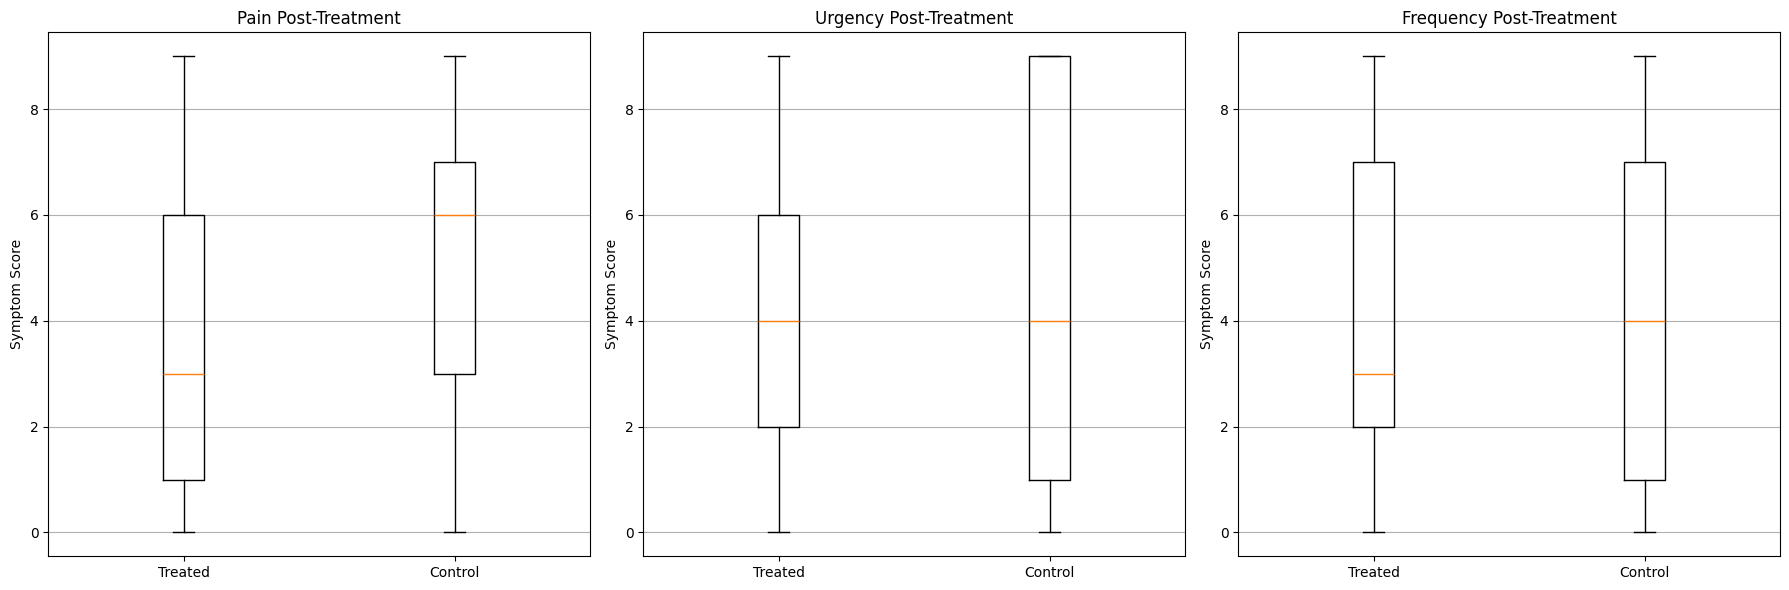

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.stats import wilcoxon
from scipy.linalg import inv
import pulp

# Step 1: Simulate Data (Replace with real dataset)
np.random.seed(42)
num_patients = 200
dataset = pd.DataFrame({
    'patient_id': np.arange(1, num_patients + 1),
    'pain_baseline': np.random.randint(0, 10, num_patients),
    'urgency_baseline': np.random.randint(0, 10, num_patients),
    'frequency_baseline': np.random.randint(0, 10, num_patients),
    'treatment_time': np.random.choice([3, 6, 9, 12, np.nan], num_patients, p=[0.2, 0.2, 0.2, 0.2, 0.2]),
    'pain_post': np.random.randint(0, 10, num_patients),
    'urgency_post': np.random.randint(0, 10, num_patients),
    'frequency_post': np.random.randint(0, 10, num_patients)
})
dataset['treated'] = dataset['treatment_time'].notna().astype(int)

# Step 2: Mahalanobis Distance Calculation
baseline_features = ['pain_baseline', 'urgency_baseline', 'frequency_baseline']
cov_inv = inv(dataset[baseline_features].cov())

def compute_mahalanobis(vec1, vec2):
    delta = vec1 - vec2
    return np.sqrt(delta.T @ cov_inv @ delta)

# Step 3: Optimal Matching via Integer Programming
problem = pulp.LpProblem("Patient_Matching", pulp.LpMinimize)

# Defining potential match pairs
potential_pairs = [(t_idx, c_idx) for t_idx in dataset.index for c_idx in dataset.index
                   if t_idx != c_idx and dataset.loc[t_idx, 'treated'] and not dataset.loc[c_idx, 'treated']]

# Decision variables
match_decision = {pair: pulp.LpVariable(f"match_{pair[0]}_{pair[1]}", cat='Binary') for pair in potential_pairs}

# Objective function
pair_distances = {pair: compute_mahalanobis(dataset.loc[pair[0], baseline_features],
                                            dataset.loc[pair[1], baseline_features])
                  for pair in potential_pairs}
problem += pulp.lpSum(match_decision[pair] * pair_distances[pair] for pair in potential_pairs)

# Constraints
for idx in dataset.index:
    if dataset.loc[idx, 'treated']:
        problem += pulp.lpSum(match_decision[pair] for pair in potential_pairs if pair[0] == idx) == 1
    else:
        problem += pulp.lpSum(match_decision[pair] for pair in potential_pairs if pair[1] == idx) <= 1

# Solve
problem.solve()

# Step 4: Matched Pairs Extraction
final_matches = [(t, c) for (t, c) in potential_pairs if pulp.value(match_decision[(t, c)]) == 1]
matched_results = pd.DataFrame([
    (dataset.loc[t, 'pain_post'], dataset.loc[c, 'pain_post'],
     dataset.loc[t, 'urgency_post'], dataset.loc[c, 'urgency_post'],
     dataset.loc[t, 'frequency_post'], dataset.loc[c, 'frequency_post'])
    for t, c in final_matches
], columns=['pain_treated', 'pain_control', 'urgency_treated', 'urgency_control',
            'frequency_treated', 'frequency_control'])

# Step 5: Wilcoxon Signed-Rank Test
pain_stat, pain_pval = wilcoxon(matched_results['pain_treated'], matched_results['pain_control'])
urgency_stat, urgency_pval = wilcoxon(matched_results['urgency_treated'], matched_results['urgency_control'])
frequency_stat, frequency_pval = wilcoxon(matched_results['frequency_treated'], matched_results['frequency_control'])

print("Wilcoxon Signed-Rank Test Results:")
print(f"Pain: p-value = {pain_pval:.4f}")
print(f"Urgency: p-value = {urgency_pval:.4f}")
print(f"Frequency: p-value = {frequency_pval:.4f}")

# Visualization
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Pain Graph
axs[0].boxplot([matched_results['pain_treated'], matched_results['pain_control']], labels=['Treated', 'Control'])
axs[0].set_title('Pain Post-Treatment')
axs[0].set_ylabel('Symptom Score')
axs[0].grid(axis='y')

# Urgency Graph
axs[1].boxplot([matched_results['urgency_treated'], matched_results['urgency_control']], labels=['Treated', 'Control'])
axs[1].set_title('Urgency Post-Treatment')
axs[1].set_ylabel('Symptom Score')
axs[1].grid(axis='y')

# Frequency Graph
axs[2].boxplot([matched_results['frequency_treated'], matched_results['frequency_control']], labels=['Treated', 'Control'])
axs[2].set_title('Frequency Post-Treatment')
axs[2].set_ylabel('Symptom Score')
axs[2].grid(axis='y')

plt.tight_layout()
plt.show()
